INFO – 6148

Natural Language Processing

Garvit Sakhuja

### Import necessary libraries

In [1]:
!python -m spacy download en_core_web_md
import spacy
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import numpy as np
from sklearn.svm import SVC
!pip install augmenty
import augmenty

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 17.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Load spacy's english model and the dataset

In [13]:
nlp = spacy.load('en_core_web_md')

resume = pd.read_csv('Resume.csv')
resume.head()

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


### Visualizing the Category

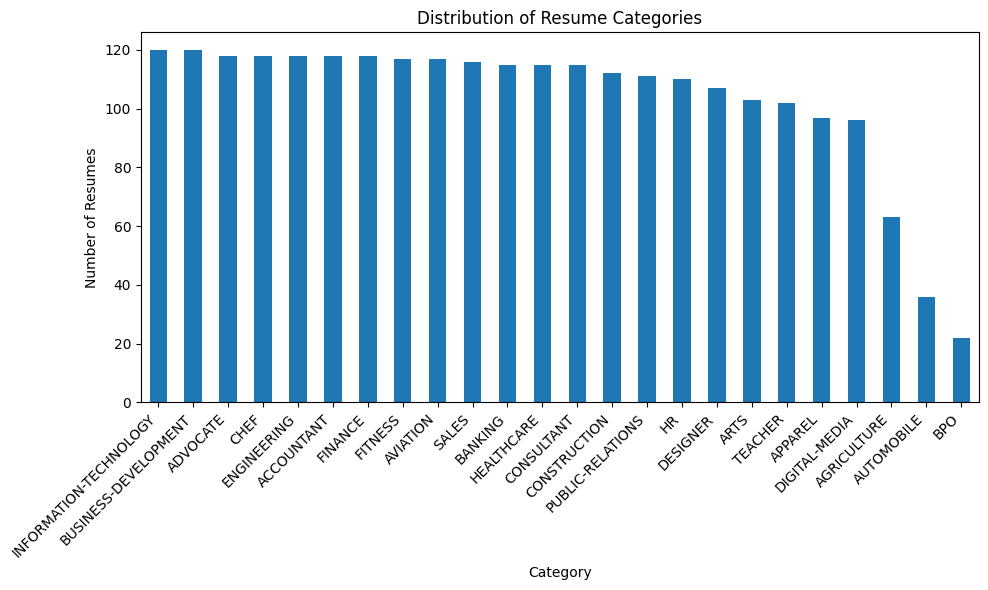

In [14]:
category_counts = resume['Category'].value_counts()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Distribution of Resume Categories')
plt.xlabel('Category')
plt.ylabel('Number of Resumes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Text Cleaning

In [15]:
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    email_pattern = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b')
    # Remove URLs
    clean_text = url_pattern.sub('', text)
    # Remove emails
    clean_text = email_pattern.sub('', clean_text)
    # Remove special characters (keeping only words and whitespace)
    clean_text = re.sub(r'[^\w\s]', '', clean_text)
    # Remove punctuations
    clean_text = re.sub(r'[^\w\s]', '', clean_text)
    clean_text = re.sub('[\W_]+', ' ', clean_text)
    # Tokenize the text
    doc = nlp(clean_text)
    tokens = [token.text for token in doc]
    # Remove stop words and lemmatize
    processed_tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(processed_tokens)

resume['processed_resume'] = resume['Resume_str'].apply(preprocess_text)
resume.head()

,ID,Resume_str,Resume_html,Category,processed_resume
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr administratormarkete associate hr administr...
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR,hr specialist hr operation summary versatile m...
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr director summary year experience recruit pl...
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr specialist summary dedicate drive dynamic y...
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr manager skill highlight hr skill hr departm...


### Visualize word counts

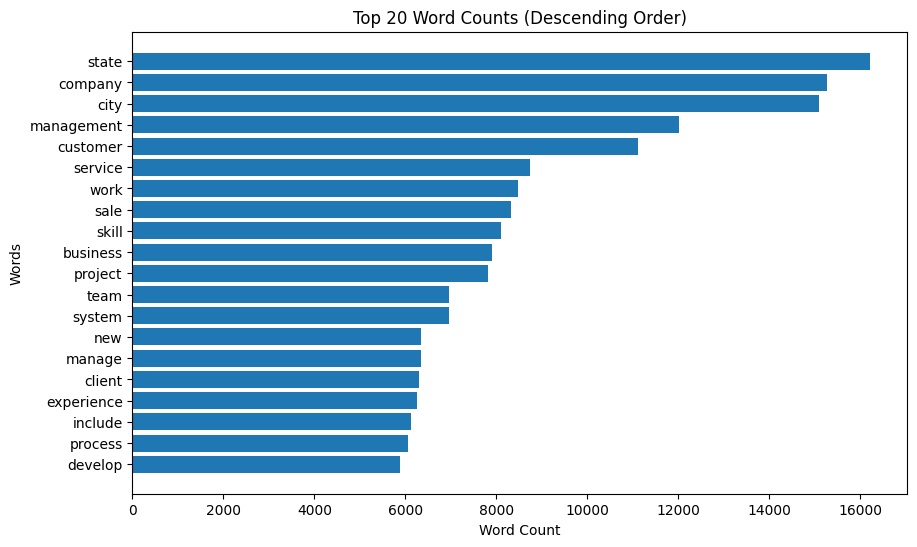

In [16]:
from collections import Counter

def plot_word_counts(text):
    words = text.split()
    word_counts = Counter(words)
    top_20_words = word_counts.most_common(20)

    word_list = [word for word, count in top_20_words]
    count_list = [count for word, count in top_20_words]

    plt.figure(figsize=(10, 6))
    plt.barh(word_list, count_list)
    plt.xlabel("Word Count")
    plt.ylabel("Words")
    plt.title("Top 20 Word Counts (Descending Order)")
    plt.gca().invert_yaxis()
    plt.show()

all_text = ' '.join(resume['processed_resume'])
plot_word_counts(all_text)

### Text Augmentation

In [17]:
# Define the augmenter for synonym replacement
synonym_augmenter = augmenty.load("wordnet_synonym_v1", level=0.1)

num_augmentations = 2000
augmented_resumes = []

for i in range(min(num_augmentations, len(resume['processed_resume']))):
    doc = nlp(resume['processed_resume'].iloc[i])

    # Apply augmentation
    augmented_docs = list(augmenty.docs([doc], augmenter=synonym_augmenter, nlp=nlp))

    # Convert augmented doc back to string
    augmented_text = augmented_docs[0].text if augmented_docs else resume['processed_resume'].iloc[i]

    augmented_resumes.append({
        'Resume_str': augmented_text,
        'Category': resume.iloc[i]['Category'],
        'processed_resume': augmented_text
    })

# Create a DataFrame for augmented resumes
augmented_df = pd.DataFrame(augmented_resumes)

# Combine with the original dataset
resume = pd.concat([resume, augmented_df], ignore_index=True)

# Reset index if necessary
resume = resume.reset_index(drop=True)

### TF-IDF Vectorization

In [18]:
resume['processed_resume'] = resume['processed_resume'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(resume['processed_resume'])
y = resume['Category']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Train the vectors using Random Forest and Support Vector Machine

In [19]:
# Random Forest with GridSearchCV
rf_model = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10]
}
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, scoring='accuracy', cv=3)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

# SVM with GridSearchCV
svm_model = SVC(random_state=42)
param_grid_svm = {
    'C': [0.1, 1.0],
    'kernel': ['linear', 'rbf']
}
grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid_svm, scoring='accuracy', cv=3)
grid_search_svm.fit(X_train, y_train)
best_svm = grid_search_svm.best_estimator_

### Evaluate both the models for TF-IDF

Random Forest Best Parameters: {'max_depth': None, 'n_estimators': 100}
Random Forest Accuracy: 0.862555720653789

Classification Report:
                         precision    recall  f1-score   support

            ACCOUNTANT       0.96      0.95      0.96        79
              ADVOCATE       0.84      0.93      0.88        68
           AGRICULTURE       0.90      0.82      0.86        34
               APPAREL       0.90      0.80      0.84        54
                  ARTS       1.00      0.10      0.18        31
            AUTOMOBILE       0.94      0.74      0.83        23
              AVIATION       0.86      0.73      0.79        33
               BANKING       0.88      0.32      0.47        44
                   BPO       1.00      1.00      1.00         9
  BUSINESS-DEVELOPMENT       0.82      0.95      0.88        63
                  CHEF       0.92      0.97      0.95        71
          CONSTRUCTION       0.83      0.96      0.89        50
            CONSULTANT      

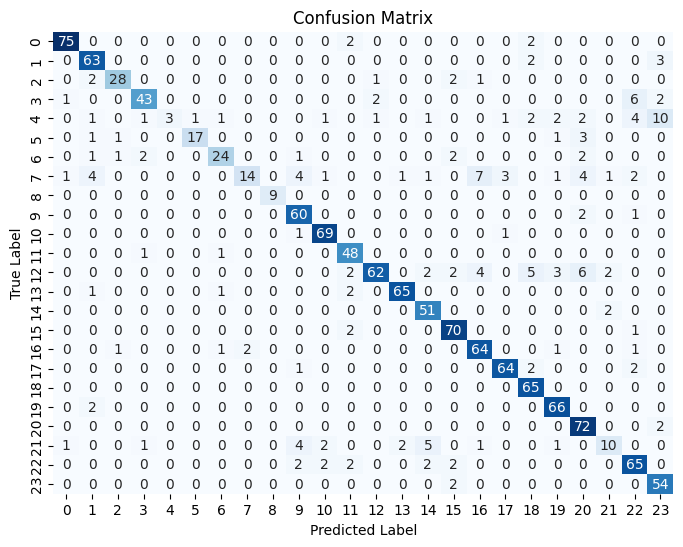

SVM Best Parameters: {'C': 1.0, 'kernel': 'rbf'}
SVM Accuracy: 0.8239227340267459

Classification Report:
                         precision    recall  f1-score   support

            ACCOUNTANT       0.91      0.95      0.93        79
              ADVOCATE       0.72      0.85      0.78        68
           AGRICULTURE       0.82      0.91      0.86        34
               APPAREL       0.78      0.70      0.74        54
                  ARTS       1.00      0.19      0.32        31
            AUTOMOBILE       1.00      0.39      0.56        23
              AVIATION       0.92      0.67      0.77        33
               BANKING       0.67      0.50      0.57        44
                   BPO       1.00      0.67      0.80         9
  BUSINESS-DEVELOPMENT       0.84      0.90      0.87        63
                  CHEF       0.94      0.94      0.94        71
          CONSTRUCTION       0.80      0.94      0.86        50
            CONSULTANT       0.86      0.64      0.73       

Text(70.72222222222221, 0.5, 'True Label')

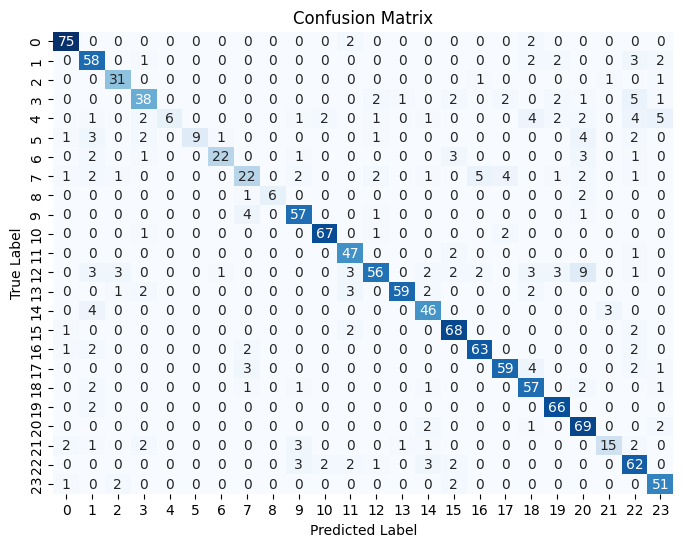

In [20]:
# Evaluate both models on the test set
rf_y_pred = best_rf.predict(X_test)
svm_y_pred = best_svm.predict(X_test)

# RandomForest evaluation
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_cr = classification_report(y_test, rf_y_pred)
rf_cm = confusion_matrix(y_test, rf_y_pred)

# SVM evaluation
svm_accuracy = accuracy_score(y_test, svm_y_pred)
svm_cr = classification_report(y_test, svm_y_pred)
svm_cm = confusion_matrix(y_test, svm_y_pred)

# Print results
print("Random Forest Best Parameters:", grid_search_rf.best_params_)
print("Random Forest Accuracy:", rf_accuracy)
print("\nClassification Report:\n", rf_cr)

plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("SVM Best Parameters:", grid_search_svm.best_params_)
print("SVM Accuracy:", svm_accuracy)
print("\nClassification Report:\n", svm_cr)

plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

### Spacy Vectorization

In [21]:
spacy_vectors = []
for doc in nlp.pipe(resume['processed_resume'], disable=["tagger", "parser", "ner"]):
    spacy_vectors.append(doc.vector)

# Convert vectors to a NumPy array
X = np.array(spacy_vectors)
y = resume['Category']

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


### Split, train and evaluate the models again for spacy vectors

Random Forest Best Parameters: {'max_depth': None, 'n_estimators': 100}
Random Forest Accuracy: 0.7726597325408618

Classification Report:
                         precision    recall  f1-score   support

            ACCOUNTANT       0.81      0.91      0.86        79
              ADVOCATE       0.73      0.79      0.76        68
           AGRICULTURE       0.87      0.79      0.83        34
               APPAREL       0.83      0.72      0.77        54
                  ARTS       1.00      0.16      0.28        31
            AUTOMOBILE       1.00      0.65      0.79        23
              AVIATION       0.78      0.42      0.55        33
               BANKING       0.60      0.14      0.22        44
                   BPO       0.90      1.00      0.95         9
  BUSINESS-DEVELOPMENT       0.66      0.92      0.77        63
                  CHEF       0.93      0.96      0.94        71
          CONSTRUCTION       0.66      0.88      0.75        50
            CONSULTANT     

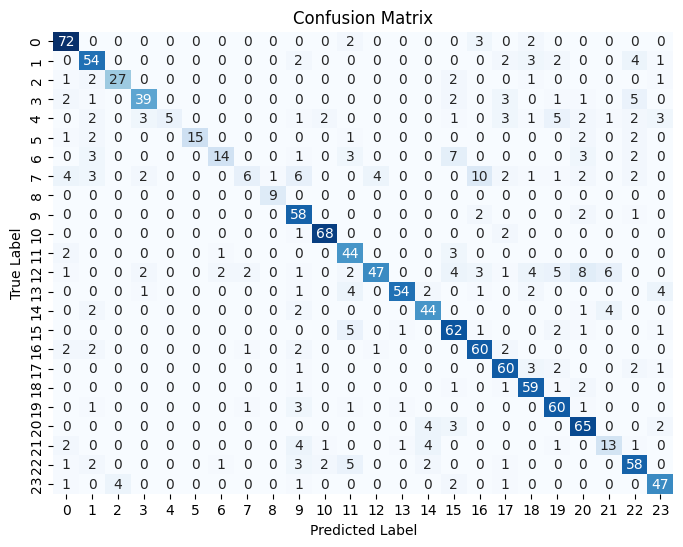

SVM Best Parameters: {'C': 1.0, 'kernel': 'linear'}
SVM Accuracy: 0.8142644873699851

Classification Report:
                         precision    recall  f1-score   support

            ACCOUNTANT       0.93      0.86      0.89        79
              ADVOCATE       0.71      0.87      0.78        68
           AGRICULTURE       0.67      0.94      0.78        34
               APPAREL       0.80      0.80      0.80        54
                  ARTS       0.67      0.26      0.37        31
            AUTOMOBILE       0.58      0.83      0.68        23
              AVIATION       0.81      0.64      0.71        33
               BANKING       0.64      0.41      0.50        44
                   BPO       0.69      1.00      0.82         9
  BUSINESS-DEVELOPMENT       0.78      0.86      0.82        63
                  CHEF       0.90      0.97      0.93        71
          CONSTRUCTION       0.82      0.90      0.86        50
            CONSULTANT       0.84      0.60      0.70    

Text(70.72222222222221, 0.5, 'True Label')

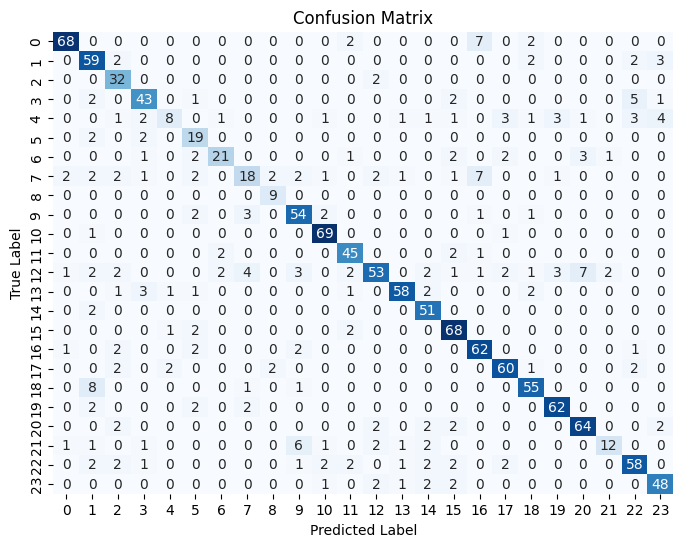

In [22]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest with GridSearchCV
rf_model = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10]
}
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, scoring='accuracy', cv=3)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

# SVM with GridSearchCV
svm_model = SVC(random_state=42)
param_grid_svm = {
    'C': [0.1, 1.0],
    'kernel': ['linear', 'rbf']
}
grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid_svm, scoring='accuracy', cv=3)
grid_search_svm.fit(X_train, y_train)
best_svm = grid_search_svm.best_estimator_

from sklearn.metrics import accuracy_score
# Evaluate both models on the test set
rf_y_pred = best_rf.predict(X_test)
svm_y_pred = best_svm.predict(X_test)

# RandomForest evaluation
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_cr = classification_report(y_test, rf_y_pred)
rf_cm = confusion_matrix(y_test, rf_y_pred)

# SVM evaluation
svm_accuracy = accuracy_score(y_test, svm_y_pred)
svm_cr = classification_report(y_test, svm_y_pred)
svm_cm = confusion_matrix(y_test, svm_y_pred)

# Print results
print("Random Forest Best Parameters:", grid_search_rf.best_params_)
print("Random Forest Accuracy:", rf_accuracy)
print("\nClassification Report:\n", rf_cr)


plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("SVM Best Parameters:", grid_search_svm.best_params_)
print("SVM Accuracy:", svm_accuracy)
print("\nClassification Report:\n", svm_cr)

plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

### Observations

Text augmentation of the Resume content improved model's performance significantly.

We trained 2 models for Resume Categorization: Random Forest and Support Vector Machine (SVM). We used two vectorization methods: TF-IDF and Spacy vectors.
After training the models are evaluated using accuracy, classification reports and confusion matrix for both tf-idf and spacy vectorization.

When comparing the results for Random Forest and SVM for TF-IDF vectors, we can see Random Forest outperforming SVM in terms of accuracy.

RF Accuracy - 86.2%

SVM Accuracy - 82.4%

When comparing the results of 2 models using spacy vectors, SVM outperforms Random Forest model here.

RF Accuracy - 77.2%

SVM Accuracy - 81.4%

Hence, we can say Random Forest is the best model for Resume Categorization using tf-idf vectorization giving an accuracy of 86.7%.





### References

1. https://realpython.com/natural-language-processing-spacy-python/

2. https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

3. https://www.analyticsvidhya.com/blog/2021/06/text-analytics-of-resume-dataset-with-nlp/

4. https://spacy.io/universe/project/augmenty

5. https://www.analyticsvidhya.com/blog/2021/06/tune-hyperparameters-with-gridsearchcv/